# Exploration of seasonal precipitation forecasts
For anticipatory action on drought, we are exploring indicators that signal the future occurence of a drought. 
The indicator we are exploring is seasonal precipitation forecasts. More specifically, we look at the probability of below-average precipitation of the probabilistic tercile forecasts. 

To develop the approach further there are two main aspects we have to better understand:
1) How can we combine the forecasts provided by different organizations? \
2) How can we aggregate the forecasts from raster cells to the spatial level which is used for decision-making?    

This highest priority is with 2), and this is what this notebook explores

For 2), three main factors have to be decided upon, namely     
- the spatial level of decision making     
- the aggregation from raster cells to that spatial level     
- the probability threshold after aggregation.

### The level of decision making
Ultimately we would like to have a drought-indicator per livelihood zone but this is not realistic due to the high uncertainty in forecasts with a longer lead time.   
At the minimum we need an indication per admin1.    
For large admin1 regions with different weather patterns, it would be great to be able to have an indication per admin2 (or weather type region).     
We should also take into account the livelihood types and seasonal calendar to determine the impact of below-average rainfall

### Possible methodologies for aggregating to decision level
Ultimately we want to know which regions meet a certain threshold of probability of below-average precipitation. 
Whether a region meets this threshold can be computed in different manners. 

We determine which raster cells fall within an admin region either by selecting those with **their centre** in the region OR by selecting cells that have **any part** inside the admin region. Each raster cell (similar to pixel) has a probability. 

**Detailed options:**

*(Each option possible whether cells were selected based on their centre or any parts being in the region.)*

1) Set the value of each admin region as the value of the cell with the **maximum probability** and trigger if that value >= *trigger_threshold*   
2) Set the value of each admin regtion as the **average value** of all cells included in the admin region and trigger if that value >= *trigger_threshold*      
3) Compute the **percentage of the admin region** that has a value higher than *probability_threshold* and trigger if this percentage is larger than *trigger_threshold_percentage*

### Our proposal
**Note: this is a very early stage proposal and meant to guide the discussion**    
a) Overlay with livelihood types and seasonal calendar to determine the regions impacted by less rainfall    
b) Compute the average value of all cells with their centre in an admin1 region. If this value is higher than 45% probability, activate       
c) Compute the maximum value of cells touching an admin2 per admin2. If any of the admin2's have a maximum value that is higher than 47.5%, activate    

### Spatial level questions:
- Could we look beyond admin regions but instead focus on e.g. climatic regions?
- Should we take into account the livelihood types and if so how?

### Aggregation methodology questions:
- Are there other possible aggregation methodologies than those mentioned above?
- Which methodology best fits our purpose?
- What is a reasonable threshold?



## CODE
Implements the above mentioned aggregation methodologies for admin2 and admin 1 level. This is done for the current forecast (2021-01) for the MAM season (2 months leadtime)     
The final part of the notebook computes the dates the proposed threshold has been met since 2017

### Load packages

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs

In [21]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from indicators.drought.config import Config

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


#### Set config values

In [22]:
country="ethiopia"
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)

In [23]:
adm1_bound_path=os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Define functions

In [24]:
def load_iri(config):    
    IRI_filepath = os.path.join(config.DROUGHTDATA_DIR, config.IRI_DIR, config.IRI_NC_FILENAME_CRS)
    # the nc contains two bands, prob and C. Still not sure what C is used for but couldn't discover useful information in it and will give an error if trying to read both (cause C is also a variable in prob)
    #the date format is formatted as months since 1960. In principle xarray can convert this type of data to datetime, but due to a wrong naming of the calendar variable it cannot do this automatically
    #Thus first load with decode_times=False and then change the calendar variable and decode the months
    iri_ds = xr.open_dataset(IRI_filepath, decode_times=False, drop_variables='C')
    iri_ds['F'].attrs['calendar'] = '360_day'
    iri_ds = xr.decode_cf(iri_ds)

    with rasterio.open(IRI_filepath) as src:
        transform = src.transform
        
    iri_ds=iri_ds.rename({"prob":"prob_below"})
    #C indicates the tercile where 0=below average
    iri_ds_below = iri_ds.sel(C=0)

    return iri_ds_below, transform

In [25]:
def resample_raster(file_path,upscale_factor):
    with rasterio.open(file_path) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )
    
    data_reshape=data.reshape(-1,data.shape[-1])

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    
    return data_reshape, transform

In [26]:
def compute_raster_statistics(boundary_path, raster_array, raster_transform, threshold, band=1, nodata=-9999, upscale_factor=None):
    """
    Compute statistics of the raster_array per geographical region defined in the boundary_path file
    Currently several methods are implemented, namely the maximum and mean per region, and the percentage of the area with a value larger than threshold.
    For all three methods, two variations are implemented: one where all raster cells touching a region are counted, and one where only the raster cells that have their center within the region are counted.
    Args:
        boundary_path (str): path to the shapefile
        raster_array (numpy array): array containing the raster data
        raster_transform (numpy array): array containing the transformation of the raster data, this is related to the CRS
        threshold (float): minimum probability of a raster cell to count that cell as meeting the criterium
        upscale_factor: currently not implemented

    Returns:
        df (Geodataframe): dataframe containing the computed statistics
    """
    df = gpd.read_file(boundary_path)
    #TODO: decide if we want to upsample and if yes, implement
    # if upscale_factor:
    #     forecast_array, transform = resample_raster(raster_path, upscale_factor)
    # else:

    # extract statistics for each polygon. all_touched=True includes all cells that touch a polygon, with all_touched=False only those with the center inside the polygon are counted.
    df["max_cell"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=raster_array, affine=raster_transform, band=band, nodata=nodata))["max"]
    df["max_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=raster_array, affine=raster_transform, all_touched=True, band=band, nodata=nodata))["max"]

    df["avg_cell"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=raster_array, affine=raster_transform, band=band, nodata=nodata))[
        "mean"]
    df["avg_cell_touched"] = pd.DataFrame(
        zonal_stats(vectors=df, raster=raster_array, affine=raster_transform, all_touched=True, band=band, nodata=nodata))[
        "mean"]

    # calculate the percentage of the area within an geographical area that has a value larger than threshold
    forecast_binary = np.where(raster_array >= threshold, 1, 0)
    bin_zonal = pd.DataFrame(
        zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, stats=['count', 'sum'], band=band, nodata=nodata))
    df['perc_threshold'] = bin_zonal['sum'] / bin_zonal['count'] * 100
    bin_zonal_touched = pd.DataFrame(
        zonal_stats(vectors=df, raster=forecast_binary, affine=raster_transform, all_touched=True, stats=['count', 'sum'], band=band, nodata=nodata))
    df['perc_threshold_touched'] = bin_zonal_touched['sum'] / bin_zonal_touched['count'] * 100

    return df

In [27]:
def plot_spatial_columns(df, col_list, title=None, predef_bins=None,cmap='YlOrRd',colp_num=2):
    """
    Create a subplot for each variable in col_list where the value for the variable per spatial region defined in "df" is shown
    If predef_bins are given, the values will be classified to these bins. Else a different color will be given to each unique value
    Args:
        df (GeoDataframe): dataframe containing the values for the variables in col_list and the geo polygons
        col_list (list of strs): indicating the column names that should be plotted
        title (str): title of plot
        predef_bins (list of numbers): bin boundaries
        cmap (str): colormap to use

    Returns:
        fig: figure with subplot for each variable in col_list
    """

    #define the number of columns and rows
    num_plots = len(col_list)
    rows = math.ceil(num_plots / colp_num)
    position = range(1, num_plots + 1)

    fig = plt.figure(1,figsize=(16,6*rows))
    #if bins, set norm to classify the values in the bins
    if predef_bins is not None:
        scheme = None
        norm = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
        legend_kwds=None
    else:
        scheme = "natural_breaks"
        norm = None
        legend_kwds = {'bbox_to_anchor': (1.6, 1)}

    for i, col in enumerate(col_list):
        ax = fig.add_subplot(rows, colp_num, position[i])

        #if no predef bins, set unique color for each unique value
        if predef_bins is None:
            colors = len(df[col].dropna().unique())
        #else colors will be determined by norm and cmap
        else:
            colors = None

        if df[col].isnull().values.all():
            print(f"No not-NaN values for {col}")
        #cannot handle missing_kwds if there are no missing values, so have to define those two cases separately
        elif df[col].isnull().values.any():
            df.plot(col, ax=ax, legend=True, k=colors, cmap=cmap, norm=norm, scheme=scheme,
                    legend_kwds=legend_kwds,
                    missing_kwds={"color": "lightgrey", "edgecolor": "red",
                                  "hatch": "///",
                                  "label": "No values"})
        else:
            df.plot(col, ax=ax, legend=True, k=colors, cmap=cmap, norm=norm, scheme=scheme,
                    legend_kwds=legend_kwds
                    )

        df.boundary.plot(linewidth=0.2, ax=ax)

        plt.title(col)
        ax.axis("off")
        plt.axis("off")

        #prettify legend if using individual color for each value
        if predef_bins is None and not df[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text = upper
                lbl.set_text(new_text)

    #TODO: fix legend and prettify plot
    if title:
        fig.suptitle(title, fontsize=14, y=0.92)

In [28]:
def plot_raster_boundaries_clip(ds_list, boundary_path, clipped=True, lon='lon',lat='lat',forec_val='prob_below',title_list=None,suptitle=None,colp_num=2,predef_bins = np.arange(30, 61, 2.5),figsize=(6.4, 4.8),labelsize=8):
    #compared to plot_raster_boundaries, this function is working with clipped values and a list of datasets
    """
    Plot a raster file and a shapefile on top of each other.
    Several datasets can given and for each dataset a separate subplot will be generated
    Args:
        ds_nc (xarray dataset): dataset that should be plotted, all bands contained in this dataset will be plotted
        boundary_path (str): path to the shapefile
        clipped (bool): if True, clip the raster extent to the shapefile
        lon (str): name of the longitude coordinate in ds_nc
        lat (str): name of the latitude coordinate in ds_nc
        forec_val (str): name of the variable that contains the values to be plotted in ds_nc
        title_list (list of strs): titles of subplots. If None, no subtitles will be used
        suptitle (str): general figure title. If None, no title will be used
        colp_num (int): number of columns in figure
        predef_bins (array/list): array/list with bins to classify the values in
        figsize(tuple): width, height of the figure in inches
        labelsize(float): size of legend labels and subplot titles
    Returns:
        fig (fig): two subplots with the raster and the country and world boundaries
    """
    #initialize empty figure, to circumvent that figures from different functions are overlapping
    plt.figure()

    # load admin boundaries shapefile
    df_bound = gpd.read_file(boundary_path)

    num_plots = len(ds_list)
    rows = math.ceil(num_plots / colp_num)
    position = range(1, num_plots + 1)

    norm = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
    cmap="YlOrRd" #plt.cm.jet
    fig, axes = plt.subplots(rows, colp_num,figsize=figsize)
    if num_plots==1:
        axes.set_axis_off()
    else:
        [axi.set_axis_off() for axi in axes.ravel()]

    for i, ds in enumerate(ds_list):
        #TODO: decide if want to use projection and if Robinson is then good one
        ax = fig.add_subplot(rows, colp_num, position[i],projection=ccrs.Robinson())

        if clipped:
            ds = ds.rio.set_spatial_dims(x_dim=lon,y_dim=lat).rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
        lons = ds.coords[lon]
        lats = ds.coords[lat]
        prob = ds[forec_val]

        im = plt.pcolormesh(lons, lats, prob, cmap=cmap, norm=norm)

        if title_list is not None:
            plt.title(title_list[i], size=labelsize)

        df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
        ax.axis("off")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = plt.colorbar(im, cax=cbar_ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.set_label(forec_val, size=labelsize, rotation=90, labelpad=15)
    cb.ax.tick_params(labelsize=labelsize)

    if suptitle is not None:
        fig.suptitle(suptitle, size=10)
    return fig

### Load data and compute aggregations

In [110]:
ds,transform=load_iri(config)

In [111]:
ds

<xarray.Dataset>
Dimensions:      (F: 47, L: 4, lat: 181, lon: 360)
Coordinates:
  * lat          (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon          (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * L            (L) float32 1.0 2.0 3.0 4.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-01-16 00:00:00
    spatial_ref  int64 ...
Data variables:
    prob_below   (F, L, lat, lon) float64 ...
Attributes:
    grid_mapping:  spatial_ref

In [112]:
#MAM season
ds_l2=ds.sel(F=cftime.Datetime360Day(2021, 1, 16, 0, 0, 0, 0),L=2)

<Figure size 432x288 with 0 Axes>

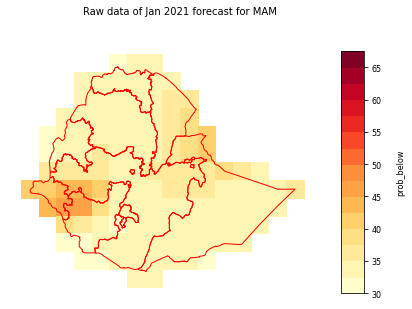

In [32]:
fig=plot_raster_boundaries_clip([ds_l2],adm1_bound_path,colp_num=1,predef_bins=np.arange(30,70,2.5),suptitle="Raw data of Jan 2021 forecast for MAM")

### Interpolation
Interpolate the values to get a more granular grid. This gives a more realistic idea of the actual forecast when using an average or percentage-based aggregation. 
On boundaries of two raster cells, the interpolation doesn't always seem entirely correct. I don't know what this is caused by and [asked the StackOverflow](https://stackoverflow.com/questions/65934263/how-does-xarrays-interp-nearest-method-choose-the-nearest-center) community but without success so far. 


In [106]:
def interpolate_ds(ds,transform,upscale_factor):
    # Interpolated data
    new_lon = np.linspace(ds.lon[0], ds.lon[-1], ds.dims["lon"] * upscale_factor)
    new_lat = np.linspace(ds.lat[0], ds.lat[-1], ds.dims["lat"] * upscale_factor)

    #choose nearest as interpolation method to assure no new values are introduced but instead old values are divided into smaller raster cells
    dsi = ds.interp(lat=new_lat, lon=new_lon,method="nearest")
    transform_interp=transform*transform.scale(len(ds.lon)/len(dsi.lon),len(ds.lat)/len(dsi.lat))
    
    return dsi, transform_interp

In [107]:
# #use to get the correct transform
# IRI_filepath = os.path.join(config.DROUGHTDATA_DIR, config.IRI_DIR, config.IRI_NC_FILENAME_CRS)
# upscale_factor=4
# with rasterio.open(IRI_filepath) as dataset:
#     # resample data to target shape
#     data = dataset.read(
#         out_shape=(
#             dataset.count,
#             int(dataset.height * upscale_factor),
#             int(dataset.width * upscale_factor)
#         ),
#         resampling=Resampling.nearest
#     )

# # scale image transform
# transform_reshape = dataset.transform * dataset.transform.scale(
#     (dataset.width / data.shape[-1]),
#     (dataset.height / data.shape[-2])
# )

In [135]:
ds_interp,transform_interp=interpolate_ds(ds,transform,4)

In [136]:
#MAM season
ds_l2_interp=ds_interp.sel(F=cftime.Datetime360Day(2021, 1, 16, 0, 0, 0, 0),L=2)

<Figure size 432x288 with 0 Axes>

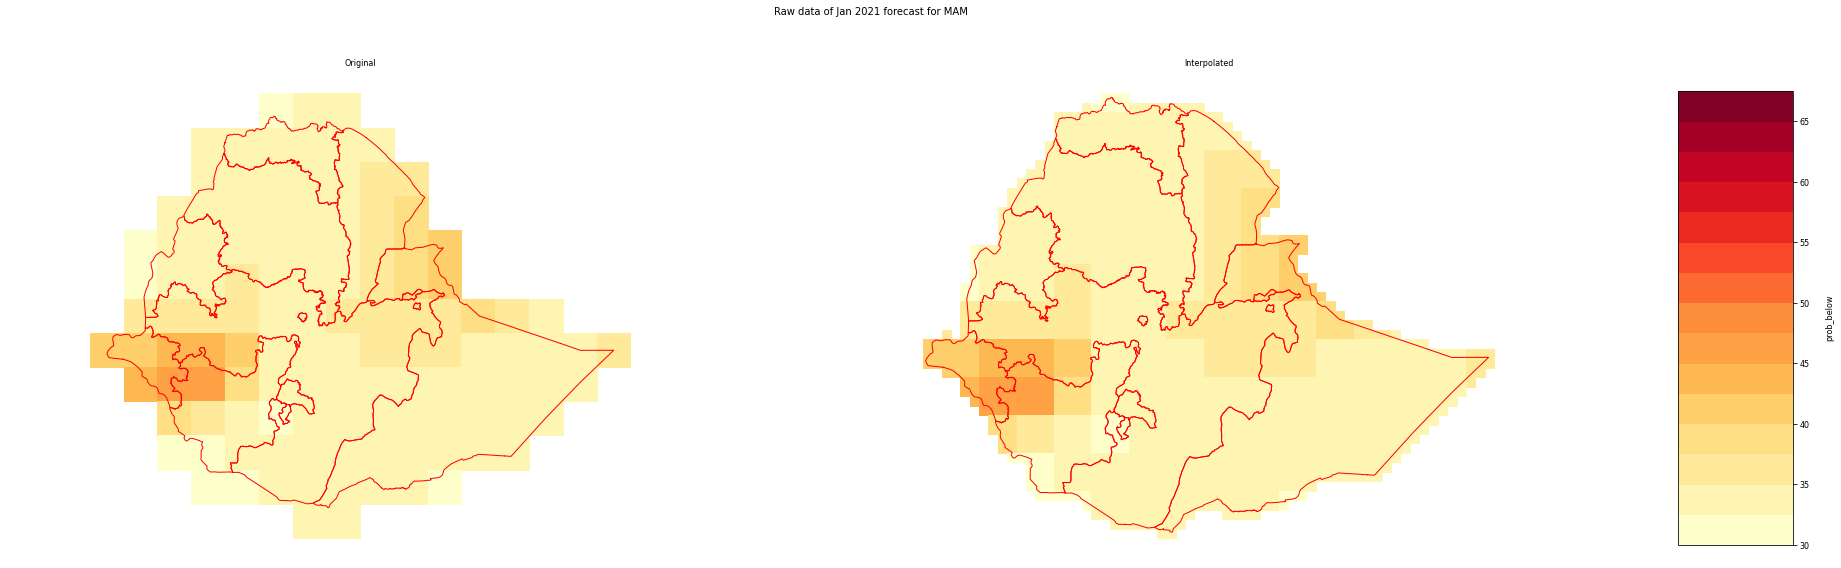

In [137]:
fig=plot_raster_boundaries_clip([ds_l2,ds_l2_interp],adm1_bound_path,colp_num=2,predef_bins=np.arange(30,70,2.5),figsize=(32,9),suptitle="Raw data of Jan 2021 forecast for MAM",title_list=["Original","Interpolated"])

In [138]:
#threshold of probability of below average, used to compute percentage of area above that probability
probability_threshold=50

In [139]:
#compute the different aggregation methodologies per admin1
df_stats=compute_raster_statistics(adm1_bound_path,ds_l2_interp["prob_below"].values,transform_interp,probability_threshold)

In [140]:
stats_cols=['max_cell', 'max_cell_touched', 'avg_cell', 'avg_cell_touched']
stats_perc_cols = ['perc_threshold', 'perc_threshold_touched']
bins_list=np.arange(30,70,2.5)
bins_perc_list=np.arange(0,50,5)

In [122]:
#highlight the max values
df_stats[["ADM1_EN"]+stats_cols+stats_perc_cols].style.highlight_max(color = 'orange', axis = 0)

,ADM1_EN,max_cell,max_cell_touched,avg_cell,avg_cell_touched,perc_threshold,perc_threshold_touched
0,Addis Ababa,nan,33.550331,nan,33.550331,nan,0.000000
1,Afar,38.793345,38.793345,35.700047,35.717921,0.000000,0.000000
2,Amhara,35.161237,35.161237,34.271203,34.241032,0.000000,0.000000
3,Benishangul Gumz,36.319732,36.602373,33.822467,33.978597,0.000000,0.000000
4,Dire Dawa,38.644045,38.644045,38.644045,38.140439,0.000000,0.000000
5,Gambela,47.028982,47.028982,42.933688,42.813428,0.000000,0.000000
6,Harari,37.133228,37.133228,37.133228,37.133228,0.000000,0.000000
7,Oromia,44.694937,45.025391,35.250301,35.290160,0.000000,0.000000
8,Sidama,33.125891,33.125891,32.842718,32.839954,0.000000,0.000000
9,SNNP,47.028982,47.028982,36.616606,36.874122,0.000000,0.000000


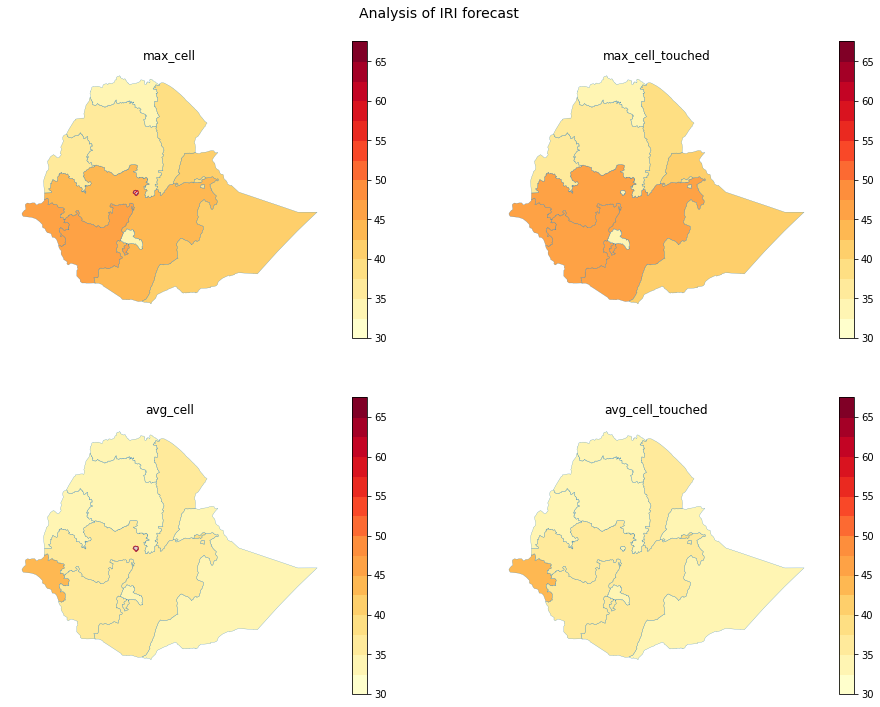

In [126]:
#plot the value per region
plot_spatial_columns(df_stats,stats_cols,
                title="Analysis of IRI forecast",predef_bins=bins_list)

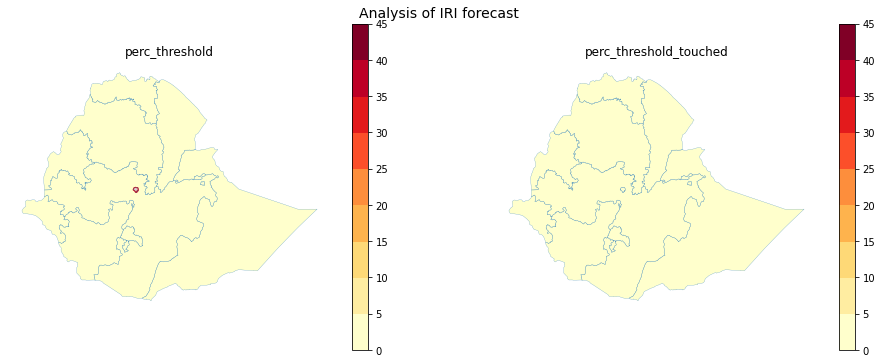

In [127]:
plot_spatial_columns(df_stats,stats_perc_cols,
                title="Analysis of IRI forecast",predef_bins=bins_perc_list)

### ADM2

In [128]:
#compute the different aggregation methodologies per admin1
df_stats_adm2=compute_raster_statistics(adm2_bound_path,ds_l2_interp["prob_below"].values,transform_interp,probability_threshold)

In [129]:
#orange is max values
# df_stats_adm2[["ADM2_EN"]+stats_cols+stats_perc_cols].style.highlight_max(color = 'orange', axis = 0)

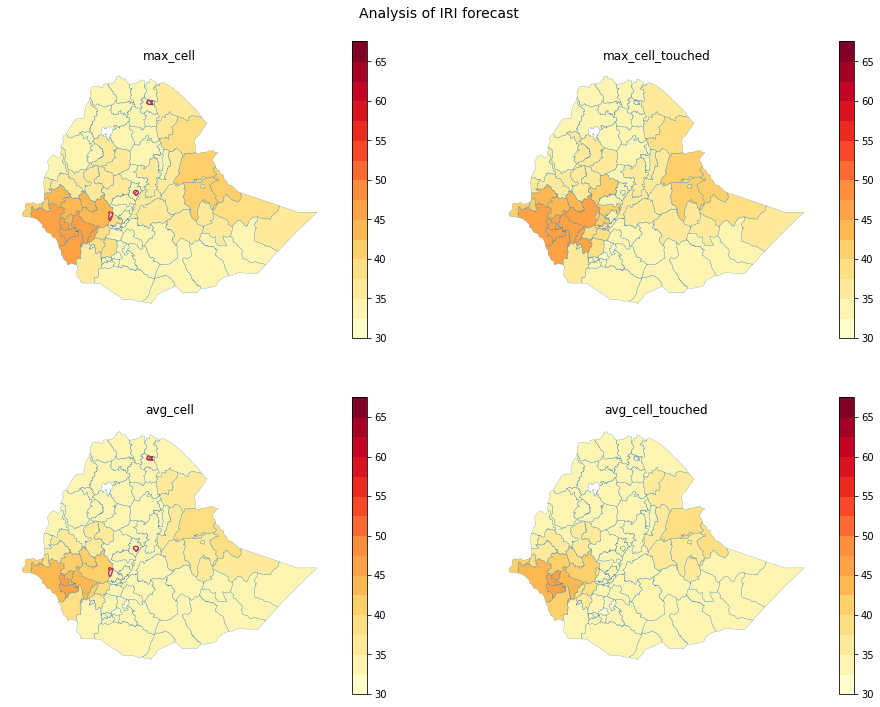

In [130]:
#red = nan values. Occurs in left column if no cell has its center within that region
plot_spatial_columns(df_stats_adm2,stats_cols,
                title="Analysis of IRI forecast",predef_bins=bins_list)

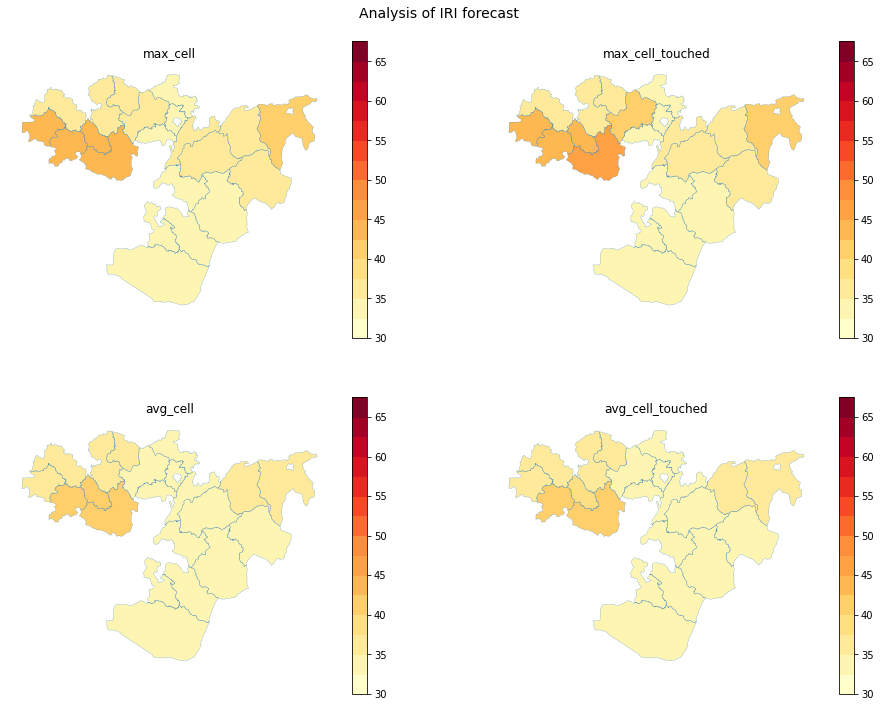

In [131]:
#to determine if different patterns within large adm1
plot_spatial_columns(df_stats_adm2[df_stats_adm2.ADM1_EN=="Oromia"],stats_cols,
                title="Analysis of IRI forecast",predef_bins=bins_list)

### Historical analysis

In [142]:
probability_threshold=50
percentage_threshold=20
leadtime=2

In [143]:
def prob_histograms(df,col_list,ylim=None,xlim=None):
    #plot histogram for each entry in col_list
    fig = plt.figure(1,figsize=(16,4))

    for i,col in enumerate(col_list):
        ax = fig.add_subplot(1,len(col_list),i+1)
        df[col].plot.hist(bins=20,ax=ax)
        plt.title(f"Histogram {col} \n NaN values: {df[col].isna().sum()}")
        ax.set_xlabel(col)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(df[col_list].min().min()-5,df[col_list].max().max()+5)
        if ylim:
            ax.set_ylim(ylim[0],ylim[1])
        if xlim:
            ax.set_xlim(xlim[0],xlim[1])

In [144]:
def alldates_statistics(ds,transform,prob_threshold,perc_threshold,leadtime,adm_path):
    #compute statistics on level in adm_path for all dates in ds
    df_list=[]
    ds=ds.sel(L=leadtime)
    print(f"Number of forecasts: {len(ds.F)}")
    for date in ds.F.values:
        ds_date=ds.sel(F=date)
        df=compute_raster_statistics(adm_path,ds_date["prob_below"].values,transform,prob_threshold)
        df["date"]=pd.to_datetime(date.strftime("%Y-%m-%d"))
        df_list.append(df)
    df_hist=pd.concat(df_list)
    df_hist=df_hist.sort_values(by="date")

    for m in ["max_cell","max_cell_touched","avg_cell","avg_cell_touched"]:
        df_hist[f"{m}_ge{prob_threshold}"]=np.where(df_hist[m]>=prob_threshold,1,0)
    df_hist[f"perc_threshold_ge{perc_threshold}"]=np.where(df_hist["perc_threshold"]>=perc_threshold,1,0)
    df_hist[f"perc_threshold_touched_ge{perc_threshold}"]=np.where(df_hist["perc_threshold_touched"]>=perc_threshold,1,0)
    
    df_hist["date_str"]=df_hist["date"].dt.strftime("%Y-%m")
    df_hist["pred_date"]=df_hist.date+pd.offsets.DateOffset(months=leadtime)
    #valid for period of 3 months, i.e. till 2 months later than first month
    df_hist["pred_date_end"]=df_hist.date+pd.offsets.DateOffset(months=leadtime+2)
    df_hist["pred_date_form"]=df_hist["pred_date"].apply(lambda x: x.strftime("%b"))
    df_hist["pred_date_end_form"]=df_hist["pred_date_end"].apply(lambda x: x.strftime("%b %Y"))
    df_hist["forec_valid"]=df_hist[["pred_date_form","pred_date_end_form"]].agg(" - ".join,axis=1)
    
    return df_hist

In [147]:
#compute aggregated values on adm1 for all dates since Jan 2017
df_hist=alldates_statistics(ds_interp,transform_interp,probability_threshold,percentage_threshold,leadtime,adm1_bound_path)

Number of forecasts: 47


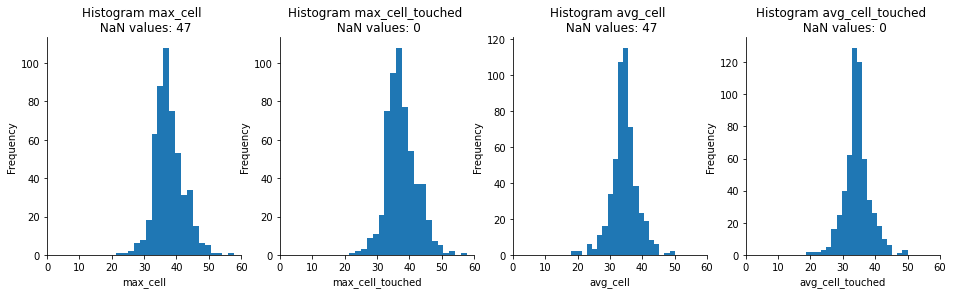

In [148]:
prob_histograms(df_hist,stats_cols,xlim=(0,60))

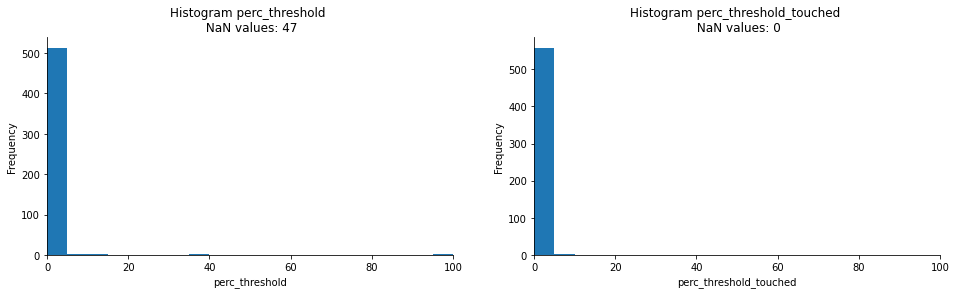

In [149]:
prob_histograms(df_hist,stats_perc_cols,xlim=(0,df_hist.perc_threshold.max()))

In [150]:
#binned values of max cell touched on adm1 for all history
pd.cut(df_hist.groupby("date").max()["max_cell_touched"],np.arange(30,60,2.5)).value_counts().sort_index(ascending=False)

(55.0, 57.5]     0
(52.5, 55.0]     1
(50.0, 52.5]     0
(47.5, 50.0]     3
(45.0, 47.5]     8
(42.5, 45.0]     9
(40.0, 42.5]    10
(37.5, 40.0]    12
(35.0, 37.5]     3
(32.5, 35.0]     0
(30.0, 32.5]     0
Name: max_cell_touched, dtype: int64

In [151]:
#binned values of avg cell on adm1 for all history
pd.cut(df_hist.groupby("date").max()["avg_cell"],np.arange(30,60,2.5)).value_counts().sort_index(ascending=False)

(55.0, 57.5]     0
(52.5, 55.0]     0
(50.0, 52.5]     1
(47.5, 50.0]     0
(45.0, 47.5]     2
(42.5, 45.0]     4
(40.0, 42.5]    11
(37.5, 40.0]    13
(35.0, 37.5]    14
(32.5, 35.0]     2
(30.0, 32.5]     0
Name: avg_cell, dtype: int64

In [152]:
#values of perc threhold on adm1 for all history
df_hist.value_counts("perc_threshold").sort_index(ascending=False)

perc_threshold
100.000000      1
37.530864       1
10.798122       1
7.901235        1
4.918033        1
4.784689        1
0.000000      511
dtype: int64

#### Historical analysis admin2

In [153]:
df_hist_adm2=alldates_statistics(ds_interp,transform_interp,probability_threshold,percentage_threshold,leadtime,adm2_bound_path)

Number of forecasts: 47


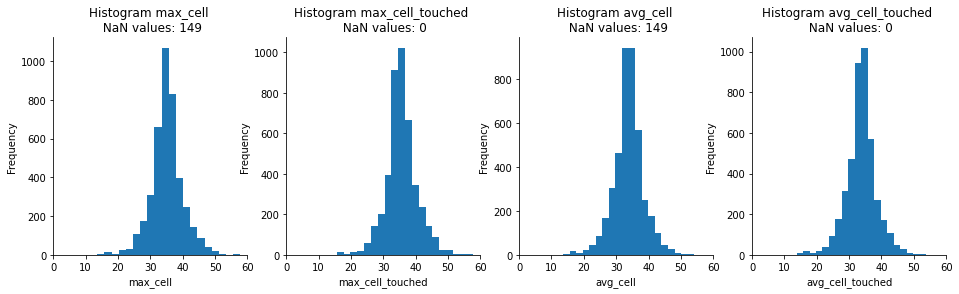

In [154]:
prob_histograms(df_hist_adm2,stats_cols,xlim=(0,60))

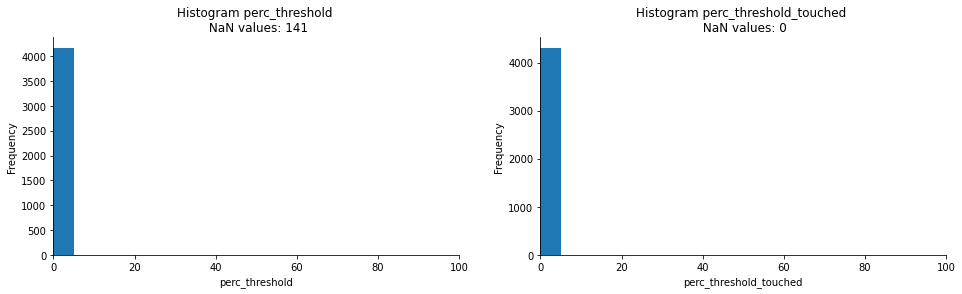

In [156]:
prob_histograms(df_hist_adm2,stats_perc_cols,xlim=(0,df_hist.perc_threshold.max()))

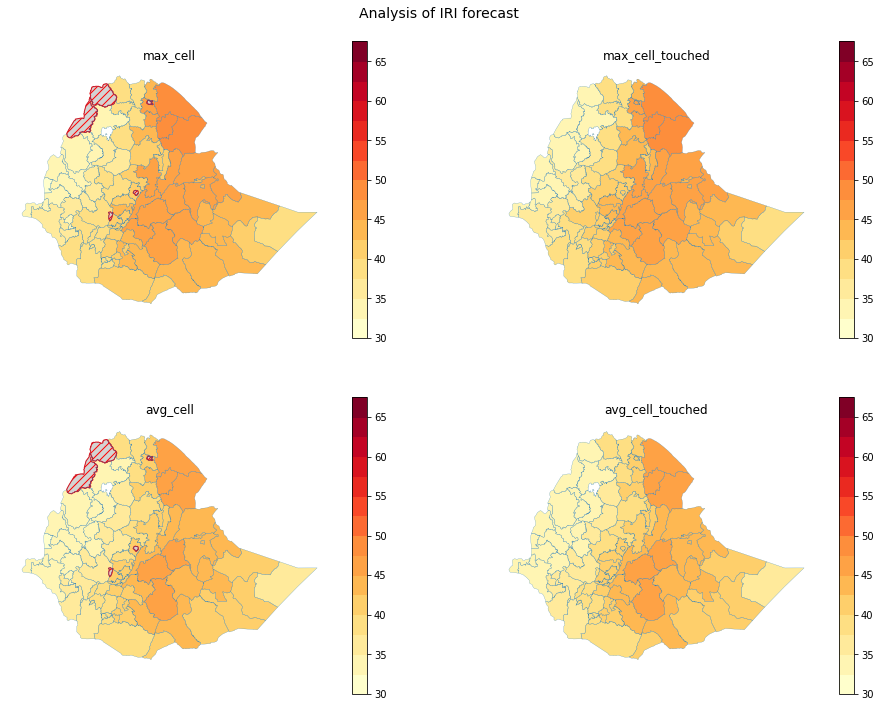

In [157]:
plot_spatial_columns(df_hist_adm2[df_hist_adm2.date=="2020-10-16"],stats_cols,
                title="Analysis of IRI forecast",predef_bins=bins_list)

December-February 2021 has been one of the driest season forecasted by IRI since 2017. With CHIRPS data from Dec 1st till mid Jan, it seems there is indeed below average rainfall, but in the lower part of ethipia instead of mid/upper part as forecasted    
CHIRPS data: https://data.chc.ucsb.edu/products/CHIRPS-2.0/moving_12pentad/pngs/africa_east/Anomaly_12PentAccum_Current.png

### Past activations 

If using ADMIN1 percentage (of cells with probability >=50 and its center inside the region is) >0

<Figure size 432x288 with 0 Axes>

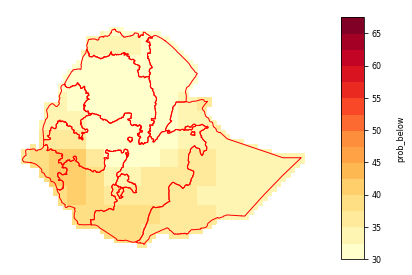

In [210]:
fig=plot_raster_boundaries_clip([ds_interp.sel(F=cftime.Datetime360Day(2018, 12, 16, 0, 0, 0, 0),L=2)],adm1_bound_path,colp_num=1,predef_bins=np.arange(30,70,2.5))

In [211]:
ds_interp

<xarray.Dataset>
Dimensions:      (F: 47, L: 4, lat: 724, lon: 1440)
Coordinates:
  * L            (L) float32 1.0 2.0 3.0 4.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-01-16 00:00:00
    spatial_ref  int64 ...
  * lat          (lat) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon          (lon) float64 -180.0 -179.8 -179.5 -179.3 ... 178.5 178.8 179.0
Data variables:
    prob_below   (F, L, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [254]:
df_bound=gpd.read_file(adm1_bound_path)
ds_interp_clip = ds_interp.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [246]:
# #this si not correct yet!
# from datetime import timedelta
# seasons={1:"JFM",2:"FMA",3:"MAM",4:"AMJ",5:"MJJ",6:"JJA",7:"JAS",8:"ASO",9:"SON",10:"OND",11:"NDJ",12:"DJF"}
# ds_interp_clip.expand_dims({"seas":[seasons[(m+d)%12] if (m+d)%12!=0 else seasons[12] for m in ds_interp_clip.F.dt.month.values for d in ds_interp_clip.L.values]})
# ds_interp_clip_l2=ds_interp_clip.sel(L=2).expand_dims({"seas":[f"{seasons[(m.dt.month.values+2)%12]} {m.dt.year.values}" if (m.dt.month.values+2)%12!=0 else seasons[12] for m in ds_interp_clip.F]})

<xarray.Dataset>
Dimensions:      (F: 47, L: 4, lat: 47, lon: 61, seas: 188)
Coordinates:
  * seas         (seas) <U3 'AMJ' 'MJJ' 'JJA' 'JAS' ... 'FMA' 'MAM' 'AMJ' 'MJJ'
  * lat          (lat) float64 14.81 14.56 14.32 14.07 ... 3.859 3.61 3.361
  * lon          (lon) float64 33.05 33.3 33.55 33.8 ... 47.28 47.52 47.77 48.02
  * L            (L) float32 1.0 2.0 3.0 4.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-01-16 00:00:00
    spatial_ref  int64 0
Data variables:
    prob_below   (seas, F, L, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [221]:
import matplotlib as mpl

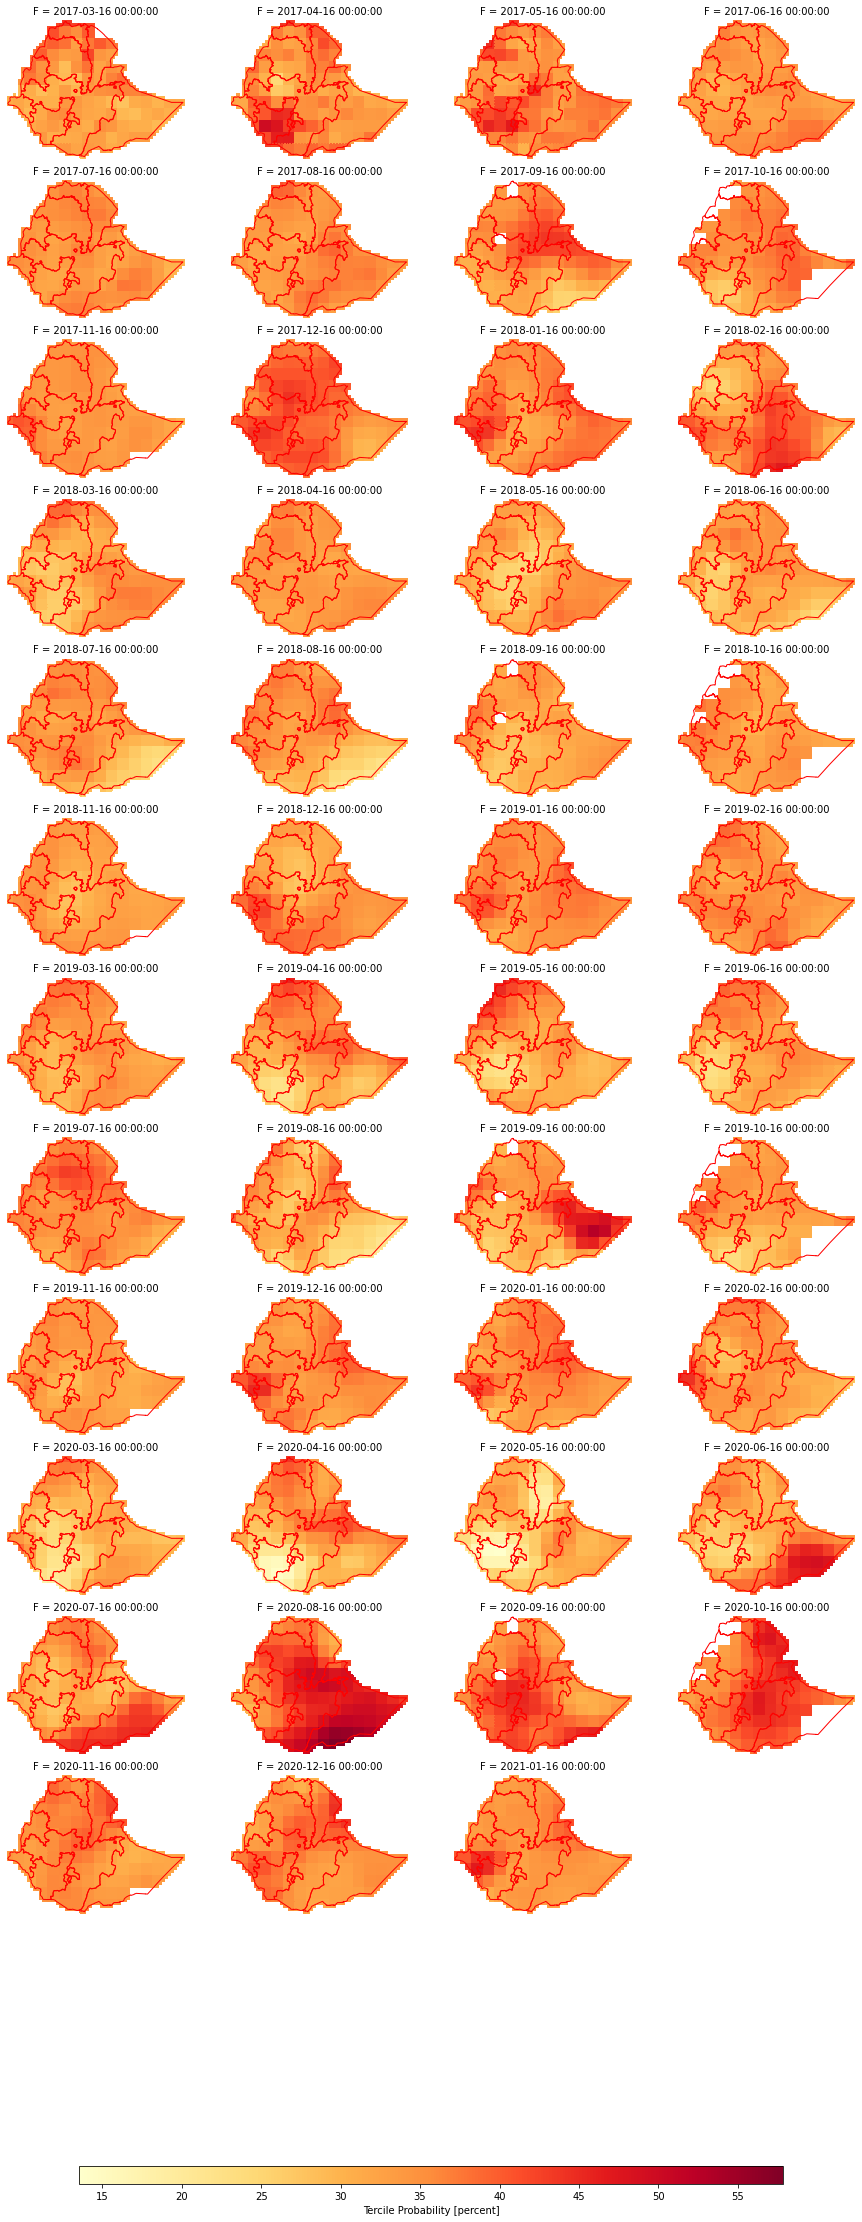

In [256]:
#inspired from https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html#facet
ds_interp_clip_l2=ds_interp_clip.sel(L=2)
g=ds_interp_clip_l2.prob_below.plot(
    col="F",
    col_wrap=4,
#     row="L",
    cmap=mpl.cm.YlOrRd, #mpl.cm.RdORYlBu_r,
#     robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

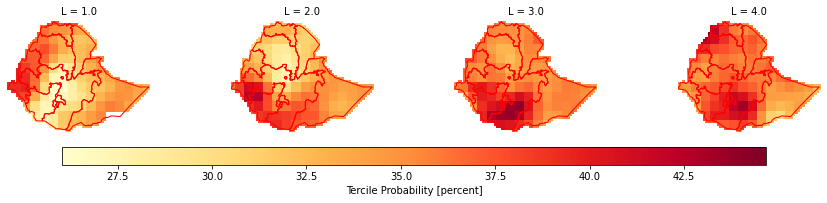

In [228]:
# ax=plt.subplot()

g=ds_interp_clip.sel(F=cftime.Datetime360Day(2018, 12, 16, 0, 0, 0, 0)).prob_below.plot(
    col="L",
    col_wrap=4,
#     row="L",
    cmap=mpl.cm.YlOrRd, #mpl.cm.RdORYlBu_r,
#     robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [207]:
df_hist[df_hist.forec_valid=="Feb - Apr 2019"][["date","forec_valid","ADM1_EN","perc_threshold","perc_threshold_touched"]+stats_cols]

,date,forec_valid,ADM1_EN,perc_threshold,perc_threshold_touched,max_cell,max_cell_touched,avg_cell,avg_cell_touched
10,2018-12-16,Feb - Apr 2019,Somali,0.0,0.0,38.348977,38.348977,34.826368,34.836849
9,2018-12-16,Feb - Apr 2019,SNNP,0.0,0.0,42.481044,42.481044,37.979539,37.902769
8,2018-12-16,Feb - Apr 2019,Sidama,0.0,0.0,36.161367,36.161367,33.904835,34.520976
7,2018-12-16,Feb - Apr 2019,Oromia,0.0,0.0,41.482027,42.481044,34.708109,34.753044
6,2018-12-16,Feb - Apr 2019,Harari,0.0,0.0,33.080555,33.080555,33.080555,33.080555
11,2018-12-16,Feb - Apr 2019,Tigray,0.0,0.0,33.234727,33.234727,32.561379,32.294046
4,2018-12-16,Feb - Apr 2019,Dire Dawa,0.0,0.0,32.592038,33.080555,32.592038,32.754877
3,2018-12-16,Feb - Apr 2019,Benishangul Gumz,0.0,0.0,36.327418,36.727328,33.155901,33.134873
2,2018-12-16,Feb - Apr 2019,Amhara,0.0,0.0,32.103605,33.234727,29.855888,29.955322
1,2018-12-16,Feb - Apr 2019,Afar,0.0,0.0,32.793029,32.793029,30.980464,30.959591


In [189]:
df_hist[df_hist.perc_threshold>0][["date","forec_valid","ADM1_EN","perc_threshold","perc_threshold_touched"]].set_index(["date","forec_valid","ADM1_EN"])

perc_threshold  perc_threshold_touched
date       forec_valid    ADM1_EN                                        
2019-09-16 Nov - Jan 2020 Somali         7.901235                6.438632
2020-08-16 Oct - Dec 2020 Oromia        10.798122                9.792844
                          Somali        37.530864               36.820926
                          Harari       100.000000              100.000000
                          Amhara         4.784689                4.580153
                          Afar           4.918033                7.361963

If using     
ADMIN 1 average of all cells with its center inside the region is >=45    
OR    
ADMIN 2 maximum value of all cells touching the region is >= 47.5

In [158]:
act_adm1=df_hist[df_hist.avg_cell>=45][["date","forec_valid","ADM1_EN","avg_cell"]]

In [168]:
act_adm1.sort_values(by=["date","ADM1_EN"]).set_index(["date","forec_valid","ADM1_EN"])

avg_cell
date       forec_valid    ADM1_EN             
2019-09-16 Nov - Jan 2020 Harari     45.115442
2020-08-16 Oct - Dec 2020 Dire Dawa  48.141195
                          Harari     50.013918
                          Somali     49.885568
2020-10-16 Dec - Feb 2021 Afar       45.142692

In [187]:
act_adm1_tuples = pd.MultiIndex.from_frame(act_adm1[["date","ADM1_EN"]])
df_hist_adm2[(df_hist_adm2.max_cell>=47.5) & ~pd.MultiIndex.from_frame(df_hist_adm2[["date","ADM1_EN"]]).isin(act_adm1_tuples)][["date","forec_valid","ADM1_EN","ADM2_EN","max_cell_touched"]].sort_values(by=["date","ADM1_EN"]).set_index(["date","forec_valid","ADM1_EN","ADM2_EN"])

max_cell_touched
date       forec_valid    ADM1_EN ADM2_EN                           
2017-04-16 Jun - Aug 2017 SNNP    Mirab Omo                49.812209
                                  South Omo                49.812209
                                  Derashe                  47.832989
                                  Alle                     47.832989
                                  Basketo                  49.812209
                                  Gofa                     49.812209
                                  Gamo                     47.832989
2019-09-16 Nov - Jan 2020 Somali  Nogob                    49.544664
                                  Korahe                   52.744330
                                  Shabelle                 49.544664
                                  Doolo                    52.744330
                                  Jarar                    52.744330
2020-06-16 Aug - Oct 2020 Somali  Korahe                   49.175260
                                  Shabelle                 49.175260
                                  Doolo                    49.175260
2020-08-16 Oct - Dec 2020 Afar    Hari /Zone 5             50.058309
                                  Gabi /Zone 3             50.628178
                          Amhara  North Shewa (AM)         50.058309
                                  Oromia                   50.058309
                                  South Wello              48.354969
                          Oromia  North Shewa (OR)         48.354969
                                  West Hararge             50.628178
                                  Borena                   52.926215
                                  Bale                     53.865897
                                  Arsi                     48.753717
                                  East Bale                51.329440
                                  Guji                     49.877660
                                  East Hararge             50.628178
                                  East Shewa               48.753717

In [190]:
#for reference, the difference when using max cell touched
act_adm1_tuples = pd.MultiIndex.from_frame(act_adm1[["date","ADM1_EN"]])
df_hist_adm2[(df_hist_adm2.max_cell_touched>=47.5) & ~pd.MultiIndex.from_frame(df_hist_adm2[["date","ADM1_EN"]]).isin(act_adm1_tuples)][["date","forec_valid","ADM1_EN","ADM2_EN","max_cell_touched"]].sort_values(by=["date","ADM1_EN"]).set_index(["date","forec_valid","ADM1_EN","ADM2_EN"])

max_cell_touched
date       forec_valid    ADM1_EN ADM2_EN                           
2017-04-16 Jun - Aug 2017 SNNP    Mirab Omo                49.812209
                                  Konta Special            49.812209
                                  Konso                    47.832989
                                  Kefa                     49.812209
                                  South Omo                49.812209
                                  Derashe                  47.832989
                                  Alle                     47.832989
                                  Basketo                  49.812209
                                  Gofa                     49.812209
                                  Gamo                     47.832989
2019-09-16 Nov - Jan 2020 Somali  Nogob                    49.544664
                                  Korahe                   52.744330
                                  Shabelle                 49.544664
                                  Doolo                    52.744330
                                  Jarar                    52.744330
2020-06-16 Aug - Oct 2020 Somali  Korahe                   49.175260
                                  Shabelle                 49.175260
                                  Doolo                    49.175260
2020-08-16 Oct - Dec 2020 Afar    Hari /Zone 5             50.058309
                                  Gabi /Zone 3             50.628178
                          Amhara  North Shewa (AM)         50.058309
                                  Oromia                   50.058309
                                  South Wello              48.354969
                          Oromia  North Shewa (OR)         48.354969
                                  West Shewa               48.354969
                                  West Hararge             50.628178
                                  Borena                   52.926215
                                  Bale                     53.865897
                                  Arsi                     48.753717
                                  East Bale                51.329440
                                  Guji                     49.877660
                                  Finfine Special          48.354969
                                  East Hararge             50.628178
                                  East Shewa               48.753717
                          SNNP    South Omo                47.586583

If using cells above 40%

In [194]:
ds_interp_40=ds_interp.where(ds_interp.prob_below>=40)

In [195]:
#compute aggregated values on adm1 for all dates since Jan 2017
df_hist_40=alldates_statistics(ds_interp_40,transform_interp,probability_threshold,percentage_threshold,leadtime,adm1_bound_path)

Number of forecasts: 47


In [198]:
act_adm1_40=df_hist_40[df_hist_40.avg_cell>=45][["date","forec_valid","ADM1_EN","avg_cell"]]

In [199]:
act_adm1_40.sort_values(by=["date","ADM1_EN"]).set_index(["date","forec_valid","ADM1_EN"])

avg_cell
date       forec_valid    ADM1_EN           
2019-09-16 Nov - Jan 2020 Harari     45.1154
                          Somali     46.1607
2020-06-16 Aug - Oct 2020 Somali     45.4635
2020-08-16 Oct - Dec 2020 Afar       45.7629
                          Dire Dawa  48.1412
                          Harari     50.0139
                          Oromia     45.9439
                          Somali     50.1045
2020-10-16 Dec - Feb 2021 Afar       45.1427
                          Tigray     45.4675
2021-01-16 Mar - May 2021 SNNP       45.2274

<Figure size 432x288 with 0 Axes>

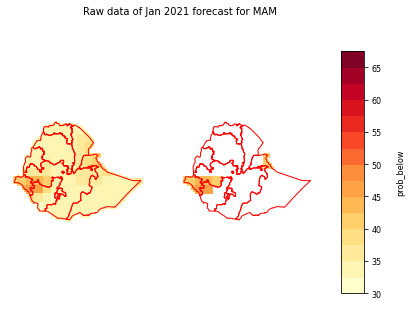

In [202]:
fig=plot_raster_boundaries_clip([ds_interp.sel(F=cftime.Datetime360Day(2021, 1, 16, 0, 0, 0, 0),L=2),ds_interp_40.sel(F=cftime.Datetime360Day(2021, 1, 16, 0, 0, 0, 0),L=2)],adm1_bound_path,colp_num=2,predef_bins=np.arange(30,70,2.5),suptitle="Raw data of Jan 2021 forecast for MAM")

#### Detail questions later in process
- Do we want to upsample the resolution if using an average or percentage based methodology?   
    - If so, what is the best upsampling methodology for our use case? Main difference between methodologies is smoother values vs introducing new values. [This](https://gisgeography.com/raster-resampling/) is a nice explanation of the different methods (now using bilinear)
- How should we define a dry mask?